# We Have Faced a Memory Leak Issue In Python

## Overview of Issue

Memory consumption is increasing over time, in front of our eyes. We were writing a FastAPI backend server FOR FUCKS SAKE.

## Overview of The Solution

LOL I ain't getting close to that bug bro. I'm doing my barely relevant adventure here.

## Overview of What This Notebook is About

This notebook is an exploration of memory profiling techniques, using a FastAPI backend as the perfect excuse. We'll be experimenting with different approaches to diagnose potential memory issues, all while maintaining a healthy distance from the actual bug that started this journey.



---

## *`Disclaimer: A Dumb and Pseudoscientific Method to Narrow Down a Bug`*

This approach may seem logical, but from a technical standpoint, it is far from sound. Here’s why:

#### 1. Information Gain is Sequence-Insensitive
In a correct probabilistic model, the value of each question should depend on the answers to previous ones. Here, information gain remains static regardless of the sequence, ignoring how earlier answers affect the relevance of later questions. **Conditional dependence** is a key principle in information theory, which this method fails to account for.

#### 2. Arbitrary Probabilities (Based on Vibes)
The probabilities used for each hypothesis were arbitrarily assigned, lacking any grounding in empirical data. Information theory assumes that probabilities reflect some **objective measure of likelihood**, but in this case, they were chosen based on intuition. Without real data, the calculations of information gain are meaningless.

#### 3. No Bayesian Updating
A more robust approach would involve **Bayesian updating**, where the probability of each hypothesis is adjusted based on the outcomes of previous questions. This static approach fails to update beliefs as new information is gathered, which is a critical flaw in narrowing down possible causes.

#### 4. Ignoring Real-World Data Correlations
We also assume that each question provides independent information, which is rarely true in real-world debugging. In practice, many factors (e.g., payload size and request lifecycle) are correlated, and this method does not account for **multicollinearity**, where questions overlap in the information they provide.

#### 5. Lack of Real Statistical Foundation
A real issue here is that **information gain isn't being applied to a well-defined statistical model**. We don’t have a proper prior distribution, nor do we consider the entropy of the system as a whole, both key components in correctly applying information theory.


### Why This Notebook?

Despite its flaws, the purpose of this notebook is to explore **information theory** in a practical context—because, frankly, it’s fascinating, even though my understanding of it is not very fascinating to put it into mild terms. This notebook will be incrementally refined (Outside of this repo maybe) to develop a more sophisticated and statistically sound approach, making it both an educational tool for myself and maybe a helpful method to assist in developing models for diagnosing system issues.


---

## 10 Hypotheses to Investigate

The following hypotheses are designed to narrow down potential causes for memory issues in a FastAPI backend server. Each question represents a possible scenario that could be contributing to the issue.

### 1. Gradual vs Spike Memory Growth (H1)
- **Why it’s important**: This helps identify if the issue is related to constant object retention or a sudden memory surge caused by specific actions.
- **What it indicates**: Gradual increases suggest memory leaks (unreleased objects), while spikes suggest event-triggered surges (e.g., large data handling). In either case, it’s clear that the memory didn’t just decide to go on vacation.

### 2. Endpoint-Specific vs Global (H2)
- **Why it’s important**: Determines whether the problem is isolated to specific API endpoints or global.
- **What it indicates**: A global problem suggests a deeper systemic issue (e.g., caching), while endpoint-specific issues could indicate a bug in individual endpoints. Of course, a global problem is our favorite kind—why deal with one bug when you can deal with *all* the bugs?

### 3. Request Lifecycle Tied (H3)
- **Why it’s important**: This will reveal if the memory increase is linked to the processing of HTTP requests.
- **What it indicates**: Tied lifecycle leaks suggest objects tied to requests are not released. Who knew that just because a request finishes, it doesn’t mean its memory wants to leave the party?

### 4. Request/Response Payload Size Sensitivity (H4)
- **Why it’s important**: Identifies if larger requests or responses increase memory usage.
- **What it indicates**: If larger payloads lead to more memory use, we may need to have a stern talk with our data processing approach. If not, well, the mystery deepens. Maybe the data is just getting *too comfortable*.

### 5. Garbage Collection Behavior (H5)
- **Why it’s important**: Tests if Python’s garbage collector can free up memory.
- **What it indicates**: If memory isn’t freed, it’s not because Python didn’t *try*. It’s because there are sneaky reference cycles or something else holding on for dear life.

### 6. Caching (H6)
- **Why it’s important**: Caching is often the culprit in memory issues due to indefinite growth.
- **What it indicates**: Unbounded caches will result in memory leaks, while bounded caches will eliminate caching as a cause. Ah yes, the good old "forgot to set a limit on the cache" scenario—classic.

### 7. Third-Party Libraries (H7)
- **Why it’s important**: Native libraries or C-extensions may cause memory leaks.
- **What it indicates**: If third-party libraries are involved, memory may be consumed outside Python’s GC. Because, naturally, the best bugs involve code someone else wrote.

### 8. Background Tasks (H8)
- **Why it’s important**: Long-running background tasks may retain memory over time.
- **What it indicates**: If background tasks contribute, you’ll need to look into how task results are managed and released. And just like that, what was once a helpful task has become a memory squatter.

### 9. I/O Operations (H9)
- **Why it’s important**: I/O-bound operations like database queries may lead to memory retention.
- **What it indicates**: A tie to I/O suggests that query results or network buffers are not released properly. Sure, we *asked* for data, but we didn’t ask for it to stay forever.

### 10. Long-Running Connections (H10)
- **Why it’s important**: WebSocket connections or other long-running sessions can accumulate memory.
- **What it indicates**: If long-running processes cause memory growth, memory is not being freed between requests. It's like a houseguest that didn’t understand the checkout time.

---

### Description of Code

The code uses the 10 hypotheses to construct a decision tree that helps guide the investigation into memory issues. Each hypothesis is evaluated for its likelihood of contributing to the problem, and based on these probabilities, we generate an optimal question sequence using a statistical measure of **information gain**. In other words, we ask the questions in the order that is most likely to narrow down the issue as quickly as possible—because the faster we find the leak, the sooner we can all pretend it never happened.

Probabilities represent the likelihood of each hypothesis being true or false. We calculate entropy to measure uncertainty and information gain to determine the value of each question.

Source: Myself


In [3]:
import math
from enum import Enum
from collections import namedtuple

class Hypotheses(Enum):
    H1 = "gradual_vs_spike"
    H2 = "endpoint_specific_vs_global"
    H3 = "request_lifecycle_tied"
    H4 = "payload_size_sensitivity"
    H5 = "garbage_collection_behavior"
    H6 = "caching_unbounded"
    H7 = "third_party_libraries"
    H8 = "background_tasks"
    H9 = "io_operations"
    H10 = "long_running_connections"

Question = namedtuple("Question", ["hypothesis", "probabilities"])

questions = [
    Question(Hypotheses.H1, [0.5, 0.5]),
    Question(Hypotheses.H2, [0.4, 0.6]),
    Question(Hypotheses.H3, [0.3, 0.7]),
    Question(Hypotheses.H4, [0.2, 0.8]),
    Question(Hypotheses.H5, [0.4, 0.6]),
    Question(Hypotheses.H6, [0.2, 0.5, 0.3]),
    Question(Hypotheses.H7, [0.6, 0.4]),
    Question(Hypotheses.H8, [0.4, 0.6]),
    Question(Hypotheses.H9, [0.5, 0.5]),
    Question(Hypotheses.H10, [0.3, 0.7])
]


## Step 4: Building the Optimal (LoL) Question Sequence

Now that we’ve defined our hypotheses, we’ll use them to create an optimal sequence of questions to ask, using information gain to decide the best order. By starting with the most informative questions, we’ll quickly eliminate unlikely causes and zero in on the root issue.

The code below generates the decision tree, calculating the entropy and information gain at each step. It will produce a state diagram representing the investigation path.


In [6]:
def calculate_entropy(probabilities):
    return -sum(p * math.log2(p) for p in probabilities if p > 0)

def calculate_information_gain(questions):
    initial_entropy = calculate_entropy([0.5, 0.5])
    question_gains = []

    for question in questions:
        entropy_after = calculate_entropy(question.probabilities)
        info_gain = initial_entropy - entropy_after
        question_gains.append((question.hypothesis, info_gain))

    return sorted(question_gains, key=lambda x: x[1], reverse=True)

ordered_questions = calculate_information_gain(questions)
ordered_hypotheses = []
# Display the hypotheses in order of most informative to least
for idx, (hypothesis, gain) in enumerate(ordered_questions, start=1):
    ordered_hypotheses.append(hypothesis)
    print(f"{idx}. {hypothesis.value} - Information Gain: {gain:.4f}")


1. payload_size_sensitivity - Information Gain: 0.2781
2. request_lifecycle_tied - Information Gain: 0.1187
3. long_running_connections - Information Gain: 0.1187
4. endpoint_specific_vs_global - Information Gain: 0.0290
5. garbage_collection_behavior - Information Gain: 0.0290
6. third_party_libraries - Information Gain: 0.0290
7. background_tasks - Information Gain: 0.0290
8. gradual_vs_spike - Information Gain: 0.0000
9. io_operations - Information Gain: 0.0000
10. caching_unbounded - Information Gain: -0.4855


## Step 7: Analysis of Information Gain Results

The information gain results show which hypotheses will most efficiently narrow down the cause of our memory issue. Starting with the highest information gain ensures that we ask the most informative questions first, reducing the problem space faster.

### Key Insights:
1. **payload_size_sensitivity (0.2781)**: This tells us that the size of request/response payloads is likely to be a major factor. If memory usage increases with payload size, it suggests we’re not handling large payloads efficiently.
   
2. **request_lifecycle_tied (0.1187)**: Tied memory increases suggest objects related to request/response processing are not being released. This is critical for diagnosing issues where memory is being consumed but not freed after requests complete.
   
3. **long_running_connections (0.1187)**: High information gain here suggests WebSocket or persistent connections may be contributing to memory retention. Long-lived sessions are a common source of memory growth.

4. **Other low-gain hypotheses**: Hypotheses like `gradual_vs_spike` (0.0000) and `caching_unbounded (-0.4855)` provide little or no new information in this case. Their low information gain means they don’t help reduce uncertainty and are less useful in narrowing down the cause.

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph for the state diagram
G = nx.DiGraph()

# Add nodes and edges to represent the decision-making process
for i in range(len(ordered_hypotheses) - 1):
    G.add_edge(ordered_hypotheses[i].name, ordered_hypotheses[i+1].name)

display(G.edges)

OutEdgeView([('H4', 'H3'), ('H3', 'H10'), ('H10', 'H2'), ('H2', 'H5'), ('H5', 'H7'), ('H7', 'H8'), ('H8', 'H1'), ('H1', 'H9'), ('H9', 'H6')])

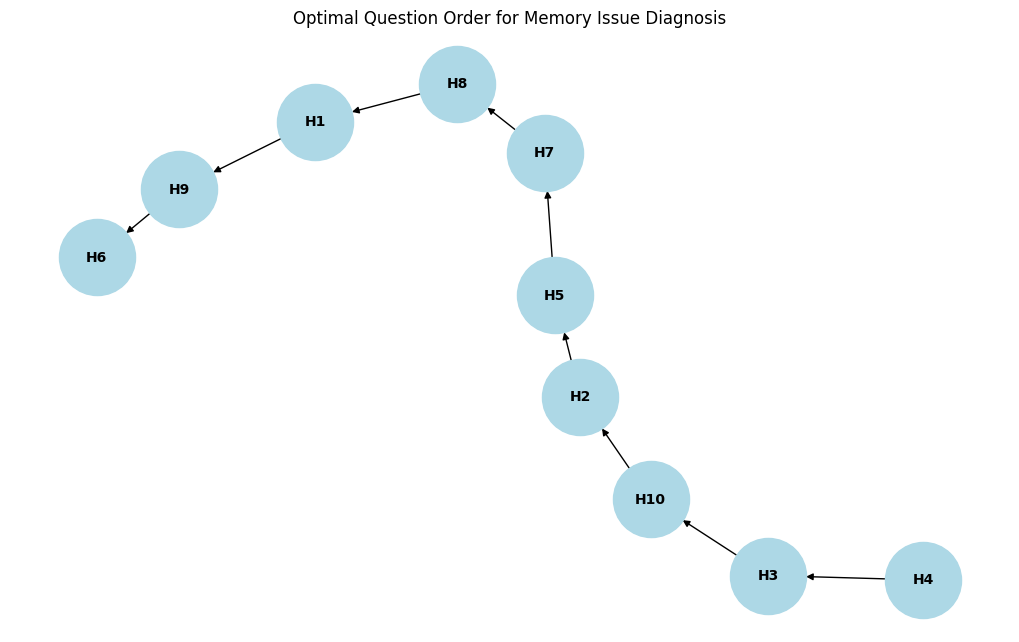

In [9]:
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)
plt.title("Optimal Question Order for Memory Issue Diagnosis")
plt.show()

## Conclusion Based on the Results

From the information gain analysis, it is clear that we should prioritize our investigation by starting with questions that provide the most insight. Here’s the recommended course of action based on the results:

1. **Payload Size Sensitivity** (Information Gain: 0.2781)  
   The most informative question to ask is whether the memory usage correlates with the size of the request or response payloads. If memory usage grows with larger payloads, this points toward inefficient handling of large data (e.g., excessive buffering or lack of streaming), which can easily cause memory bloat.

2. **Request Lifecycle Tied** (Information Gain: 0.1187)  
   Next, we need to determine whether the memory consumption is tied to the request lifecycle. If so, it suggests that objects tied to requests or responses are not being freed after completion, potentially indicating improper resource management during request processing.

3. **Long-Running Connections** (Information Gain: 0.1187)  
   Similarly, long-lived WebSocket connections or other persistent connections may be holding onto memory that isn’t being released. Investigating whether memory grows with these long-running connections can reveal whether connection handling is the culprit.

4. **Endpoint-Specific vs Global** (Information Gain: 0.0290)  
   After addressing the top priorities, we then ask whether the memory issue is specific to certain API endpoints or whether it’s a global problem. Endpoint-specific issues can indicate localized bugs in certain API calls, while global problems suggest more systemic issues.

5. **Garbage Collection Behavior** (Information Gain: 0.0290)  
   At this point, we should check if the memory is being freed by Python's garbage collector. If garbage collection isn’t reclaiming memory, we might be dealing with reference cycles or objects held by external libraries.

6. **Third-Party Libraries** (Information Gain: 0.0290)  
   If third-party libraries are in use (e.g., C-extensions or native libraries), they could be responsible for the memory retention. Memory issues in native extensions are harder to detect since they don’t rely on Python’s garbage collector.

7. **Background Tasks** (Information Gain: 0.0290)  
   If background tasks (like Celery workers or async tasks) are in play, they could be retaining memory over time. Checking whether background task results are being held unnecessarily could reveal memory leaks.

8. **Gradual vs Spike Memory Growth** (Information Gain: 0.0000)  
   Although this provides little new information, confirming whether memory increases gradually or spikes during specific events can still help us understand whether the problem is constant object retention or triggered by certain actions.

9. **I/O Operations** (Information Gain: 0.0000)  
   Next, we ask if the memory issue is related to I/O-bound operations, such as database queries or file I/O. This question didn’t provide much additional information, but it’s still worth exploring if the above factors don’t lead to a solution.

10. **Caching Unbounded** (Information Gain: -0.4855)  
   Finally, unbounded caching shows a negative information gain, meaning it adds uncertainty in this specific context. It’s less likely to be the cause here, but still worth checking last, especially if no limits were placed on the cache size.

### Summary:
To maximize efficiency, we should first investigate **payload size sensitivity** and **request lifecycle management**, followed closely by checking if long-running connections are retaining memory. From there, we proceed down the list in order of decreasing information gain, tackling systemic issues like garbage collection and third-party libraries later in the process. By following this structured approach, we can methodically narrow down the root cause of the memory issue.
